In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd


In [2]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

In [3]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    print('Date of his_weather:',nmp_df.head(10))
    print('Date of his_power:',power_df.head(10))
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    print(fix_df.head(10))
    print(fix_df.describe())
    return fix_df
# 读取数据
his_nmp_fd_df = pd.read_csv('.\\data\\FD001\\03 His_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_power_fd_df = pd.read_csv('.\\data\\FD001\\02_His_Power_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_fd_df=preprocessing(his_nmp_fd_df,his_power_fd_df)
his_fd_df.to_csv('his_df.csv',encoding = 'utf-8') #存储合并后数据
df=pd.read_csv('his_df.csv',parse_dates=["Datetime"],index_col=[0])
# 划分train valid test集
fd_df_train = df[:int(0.6*len(df))]
fd_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
fd_df_test =df[int(0.8*len(df)):]
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(fd_df_train)
df_for_validing_scaled=scaler.transform(fd_df_valid)
df_for_testing_scaled=scaler.transform(fd_df_test)
df_scaled=scaler.transform(df)
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)
df_scaled_X,df_scaled_y=createXY(df_scaled)

Date of his_weather:                      Speed10  Direction10  Speed30  Direction30  Speed50  \
Datetime                                                                   
2022-07-15 00:00:00   3.3696     290.3172   4.1829     295.0334   4.9253   
2022-07-15 00:15:00   3.3092     291.4477   4.1100     296.1286   4.8389   
2022-07-15 00:30:00   3.4671     295.0868   4.2669     299.3285   5.0000   
2022-07-15 00:45:00   3.6896     296.9123   4.4933     300.7888   5.2253   
2022-07-15 01:00:00   3.7095     298.4995   4.5220     302.3546   5.2791   
2022-07-15 01:15:00   3.5143     302.9213   4.3541     306.5014   5.1350   
2022-07-15 01:30:00   3.3300     306.6978   4.1933     310.2604   4.9758   
2022-07-15 01:45:00   3.0254     311.3819   3.9033     314.7924   4.7046   
2022-07-15 02:00:00   3.7342     313.9150   4.4407     315.3649   5.0855   
2022-07-15 02:15:00   3.1972     313.4792   4.0589     315.3993   4.8314   

                     Direction50  Speed70  Direction70  Speed90  D

In [4]:
# 建立模型函数
def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    
    return grid_model

In [5]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=-((np.array(y_true) - np.array(y_predict.flatten()))**2).sum()
    return float(difference) 

In [6]:
def build_and_ev(batch_size,epochs,size):
    grid_model=build_model(int(size))
    grid_model.fit(
    train_X, train_y,
    validation_data=(valid_X, valid_y),
    batch_size=int(batch_size),
    epochs=int(epochs),
    verbose=0)
    pred_valid_y = grid_model.predict(valid_X,verbose=0)
    score=ev(valid_y,pred_valid_y)
    return score

In [7]:
param_grid_simple = {'batch_size' : (8,32),
                     'epochs' : (16,64),
                     'size' : (16,32)}

In [8]:
#定义优化器，先实例化优化器
opt = BayesianOptimization(build_and_ev #需要优化的目标函数
                           ,param_grid_simple #备选参数空间
                           ,random_state=1412 #随机数种子
                          )

In [9]:
#使用优化器
opt.maximize(
            init_points = 20 ,#抽取多少个初始观测值
              n_iter=40 #一共观测/迭代多少次
            )

|   iter    |  target   | batch_... |  epochs   |   size    |
-------------------------------------------------------------
|  1        | -0.2102   |  29.11    |  52.1     |  17.02    |
|  2        | -0.1812   |  18.54    |  31.36    |  28.17    |
|  3        | -0.3601   |  30.11    |  58.2     |  22.25    |
|  4        | -0.2324   |  21.34    |  28.77    |  22.38    |
|  5        | -0.3164   |  14.47    |  48.84    |  17.08    |
|  6        | -0.3643   |  19.66    |  43.86    |  30.68    |
|  7        | -0.1976   |  30.36    |  24.88    |  24.21    |
|  8        | -0.3402   |  31.0     |  50.21    |  23.34    |
|  9        | -0.2228   |  14.74    |  28.59    |  21.41    |
|  10       | -0.3349   |  21.81    |  58.34    |  17.43    |
|  11       | -0.317    |  22.59    |  52.15    |  21.21    |
|  12       | -0.5119   |  17.6     |  61.54    |  16.12    |
|  13       | -0.223    |  10.44    |  28.39    |  16.52    |
|  14       | -0.2427   |  23.08    |  26.04    |  21.3     |
|  15   

In [10]:
#优化完成，取出最佳参数与最佳分数
params_best = opt.max["params"]
score_best = opt.max["target"]
#打印最佳参数与最佳分数
print("\n","\n","best params: ", params_best,
      "\n","\n","best cvscore: ", score_best)


 
 best params:  {'batch_size': 17.045971859051726, 'epochs': 26.74088868687926, 'size': 20.424964735441282} 
 
 best cvscore:  -0.160692529333368


In [11]:
my_model=build_model(int(params_best['size']))
my_model.fit(
train_X, train_y,
validation_data=(valid_X, valid_y),
batch_size=int(params_best['batch_size']),
epochs=int(params_best['epochs']),
verbose=0)
pred_valid_y = my_model.predict(valid_X)
score=ev(valid_y,pred_valid_y)

4/4 [==============================] - 0s 3ms/step


In [12]:
print(score)

-0.160692529333368


13/13 [==============================] - 0s 2ms/step


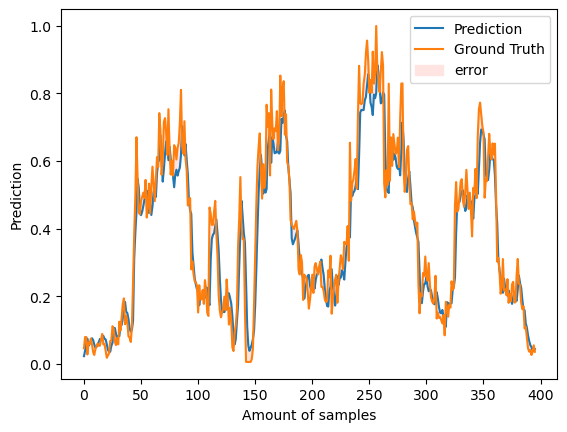

In [13]:
# 查看train集预测结果
pred_train_y = my_model.predict(train_X)
plt.plot(range(len(pred_train_y)), pred_train_y, label='Prediction')
plt.plot(range(len(pred_train_y)), train_y, label='Ground Truth')
plt.fill_between(range(len(pred_train_y)), pred_train_y.flatten(), train_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

4/4 [==============================] - 0s 3ms/step
-0.160692529333368


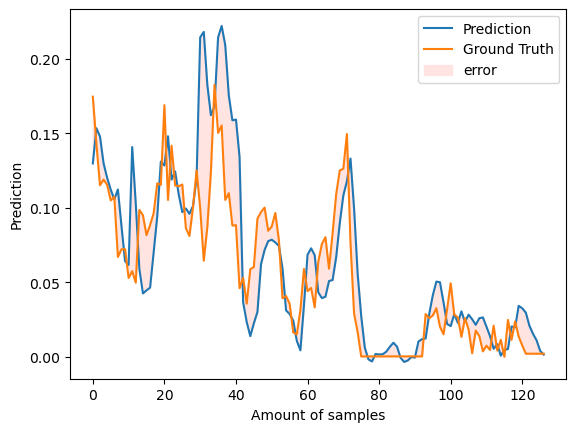

In [14]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
print(ev(valid_y,pred_valid_y))
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

4/4 [==============================] - 0s 3ms/step


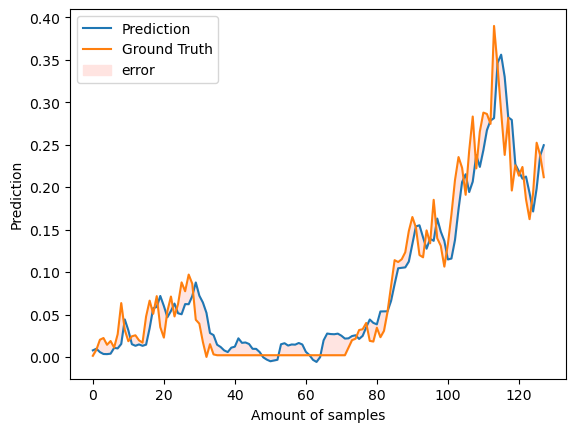

In [15]:
# 查看test集预测结果
pred_y = my_model.predict(test_X)
# %% Plotting
plt.plot(range(len(pred_y)), pred_y, label='Prediction')
plt.plot(range(len(pred_y)), test_y, label='Ground Truth')
plt.fill_between(range(len(pred_y)), pred_y.flatten(), test_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()
# %%

In [16]:
# 预测未来
# 从past数据中抽取7组作为未来数据的开头
df_30_days_past=df.iloc[-7:,:]
df_30_days_past.tail()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-21 22:45:00,4.5521,307.3230,6.1812,312.0492,7.6793,314.6835,8.4867,316.0503,8.6879,316.8657,8.7815,317.1689,27.90,1009.53,87.03,2.3584
2022-07-21 23:00:00,4.5931,308.9910,5.4076,312.4519,6.1518,314.8683,6.7197,316.4472,6.8998,317.2906,6.9864,317.6105,27.92,1010.14,0.00,2.8011
2022-07-21 23:15:00,3.3338,303.4994,4.6673,310.4815,5.9120,314.1776,6.7329,316.0832,6.9197,316.9911,7.0061,317.3137,27.44,1009.89,0.00,3.6597
2022-07-21 23:30:00,3.2299,299.8989,4.5556,308.4045,5.8027,312.7652,6.6115,314.9387,6.7961,315.8942,6.8890,316.2939,27.46,1009.84,0.00,3.4466
2022-07-21 23:45:00,3.4215,297.3140,4.7503,306.2668,6.0103,311.0873,6.7556,313.3806,6.9372,314.3576,7.0216,314.8269,27.46,1009.69,0.00,3.0725


In [17]:
# 提取未来数据
df_30_days_future=pd.read_csv('.\\data\\FD001\\04 Fore_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
df_30_days_future.shape
df_30_days_future["Power(MW)"]=0 # 为方便后续操作，为未来数据添加一power列
print(df_30_days_future.shape)
df_30_days_future.head(10)

(672, 16)


,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-22 00:00:00,3.7211,295.8076,5.0066,304.4201,6.2332,309.2053,7.0688,311.6739,7.2327,312.6467,7.3154,313.1167,27.48,1009.94,91.75,0
2022-07-22 00:15:00,3.8066,293.5346,5.0170,301.8843,6.1681,306.6284,7.2085,309.6529,7.3615,310.5929,7.4355,311.0192,27.50,1010.59,91.66,0
2022-07-22 00:30:00,3.6731,294.9604,4.9233,302.9800,6.1044,307.5457,7.1653,310.3584,7.3207,311.1786,7.4027,311.5500,27.49,1010.61,91.58,0
2022-07-22 00:45:00,3.5422,297.2161,4.8605,305.0306,6.0974,309.2762,7.0755,311.7344,7.2339,312.4229,7.3028,312.7803,27.49,1010.30,91.49,0
2022-07-22 01:00:00,3.3743,298.6918,4.7401,306.5073,6.0209,310.6219,6.9490,312.7840,7.1021,313.4025,7.1718,313.7571,27.49,1010.12,91.35,0
2022-07-22 01:15:00,3.1295,299.2680,4.5283,307.5532,5.8439,311.6010,6.7476,313.6789,6.9019,314.2956,6.9723,314.5351,27.50,1010.01,91.16,0
2022-07-22 01:30:00,2.9396,301.3649,4.3891,309.6384,5.7438,313.4480,6.5762,315.2464,6.7394,315.7815,6.8105,316.0113,27.52,1009.78,90.95,0
2022-07-22 01:45:00,2.7215,304.9748,4.1895,312.6785,5.5593,316.3119,6.3285,317.6898,6.5016,318.2420,6.5739,318.4533,27.54,1009.64,90.70,0
2022-07-22 02:00:00,3.7854,312.9661,5.0859,316.5137,6.2700,318.5562,6.9863,319.4699,7.1805,319.7449,7.2816,319.9023,26.16,1009.70,0.00,0


In [18]:
# 归一化过去数据
old_scaled_array=scaler.transform(df_30_days_past)
old_scaled_array.shape
# 归一化未来数据
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_array.shape
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,-1]=np.nan #将未来数据表中power转为NaN
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1) #合并表格


In [19]:
# 开始逐点预测
full_df_scaled_array=full_df.values
all_data=[]
time_step=7
for i in range(time_step,len(full_df_scaled_array)):
      data_x=[]
      data_x.append( full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
      data_x=np.array(data_x)
      prediction=my_model.predict(data_x)
      if prediction<0:
            prediction=0
      all_data.append(prediction)
      full_df.iloc[i,-1]=prediction

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


C:\Users\23966\AppData\Local\Temp\ipykernel_28952\2200771090.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data=np.array(all_data).flatten()


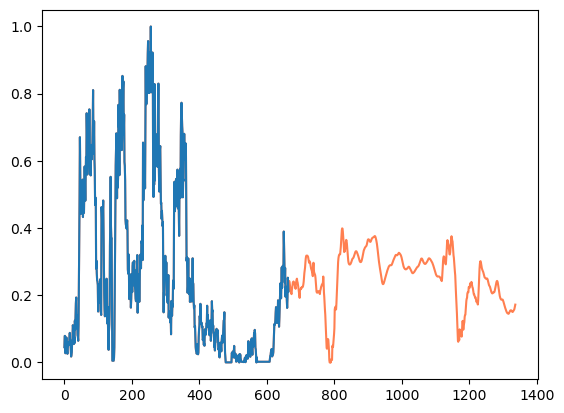

In [20]:
all_data=np.array(all_data).flatten()
#绘制整体发电量图
total = np.hstack((df_scaled_y,all_data))
plt.plot(range(len(total)), total, label='Prediction',color='coral')
plt.plot(range(len(df_scaled_y)), df_scaled_y, label='Prediction')

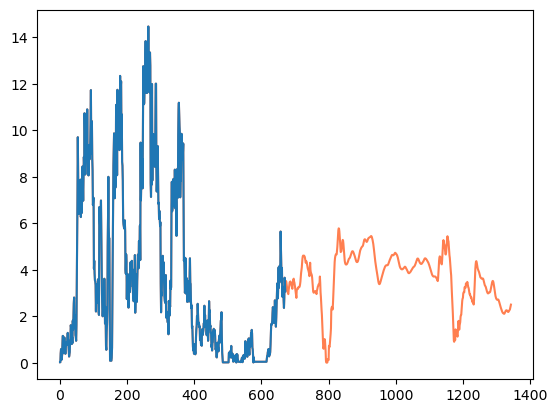

In [21]:
# 反归一化操作
df_fin=pd.read_csv('.\\data\\FD001\\04 Fore_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
len(df_fin)
df_fin['Power(MW)']=0
df_fin['Power(MW)']=all_data
df_fin
predicted_data = scaler.inverse_transform(df_fin)
fd_time=pd.read_csv('.\\data\\YC_Result_FD.csv')
fd_time['Power(MW)']=predicted_data[:,-1]
#绘制反归一化后整体发电量图
retotal = np.hstack((df['Power(MW)'],predicted_data[:,-1]))
plt.plot(range(len(retotal)), retotal, label='Prediction',color='coral')
plt.plot(range(len(df['Power(MW)'])), df['Power(MW)'], label='Prediction')

In [22]:
fd_time.to_csv('feature_fd_power_bayes.csv',index=0)